# Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis
from gemseo import from_pickle
from lh2pac.utils import update_default_inputs
from gemseo_oad_training.unit import convert_from



configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [2]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [3]:
update_default_inputs(disciplines, {"slst": 102553.5797633953, "n_pax":120, "area":113.9439805972377, "ar":13.75744220738756})
disciplines[0].io.input_grammar.defaults

{'area': 113.9439805972377, 'ar': 13.75744220738756, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [4]:
uncertain_space = ParameterSpace()

uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)

# Import surrogate model

In [5]:
surrogate_disciplines = from_pickle("UC1_my_surrogate_2.pkl")
surrogate_disciplines

Surrogate discipline: PolyReg_Sampling
   Dataset name: Sampling
   Dataset size: 20
   Surrogate model: PolynomialRegressor
   Inputs: aef, cef, sef
   Outputs: fm, length, mtom, span, tofl, vapp, vz
   Linearization mode: auto

# Create sample dataset


In [6]:
surrogate_dataset = sample_disciplines([surrogate_disciplines], uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=5000)

 WARNING - 18:25:33: No coupling in MDA, switching chain_linearize to True.
    INFO - 18:25:33: *** Start Sampling execution ***
    INFO - 18:25:33: Sampling
    INFO - 18:25:33:    Disciplines: PolyReg_Sampling
    INFO - 18:25:33:    MDO formulation: MDF
    INFO - 18:25:33: Running the algorithm OT_MONTE_CARLO:
    INFO - 18:25:49:    100%|██████████| 5000/5000 [00:15<00:00, 324.32 it/sec]
    INFO - 18:25:49: *** End Sampling execution (time: 0:00:15.478116) ***


# Check stat

In [7]:
statistics = EmpiricalStatistics(surrogate_dataset)
mean = statistics.compute_mean()
print(mean)

std = statistics.compute_standard_deviation()
print(std)

{'aef': array([1.00658106]), 'cef': array([1.00665289]), 'fm': array([0.55354989]), 'length': array([32.]), 'mtom': array([63838.41210191]), 'sef': array([1.00684398]), 'span': array([39.5926474]), 'tofl': array([1819.6300923]), 'vapp': array([65.36795331]), 'vz': array([4.88322758])}
{'aef': array([0.00848757]), 'cef': array([0.00848433]), 'fm': array([0.01342295]), 'length': array([0.]), 'mtom': array([304.3823465]), 'sef': array([0.00850743]), 'span': array([7.10542736e-15]), 'tofl': array([16.4356311]), 'vapp': array([0.17070597]), 'vz': array([0.0966382])}


# Propagate uncertainties

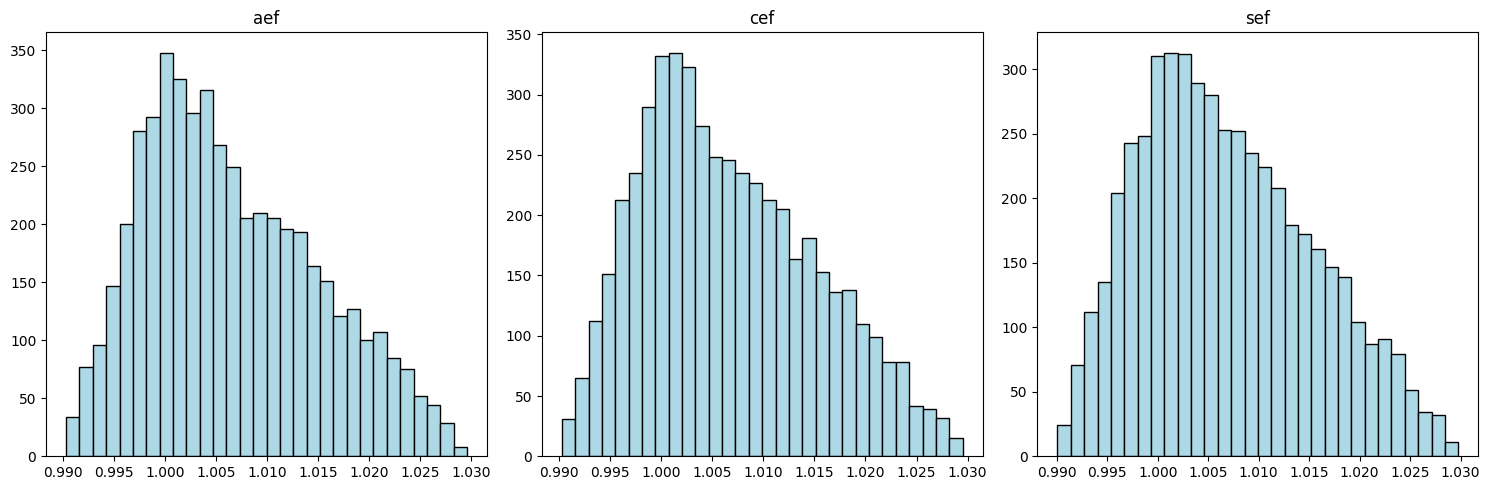

In [11]:
variable_names = ["aef", "cef", "sef"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

for ax, name in zip(axes, variable_names ):
    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='lightblue', edgecolor='black')


    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

plt.tight_layout()
plt.show()


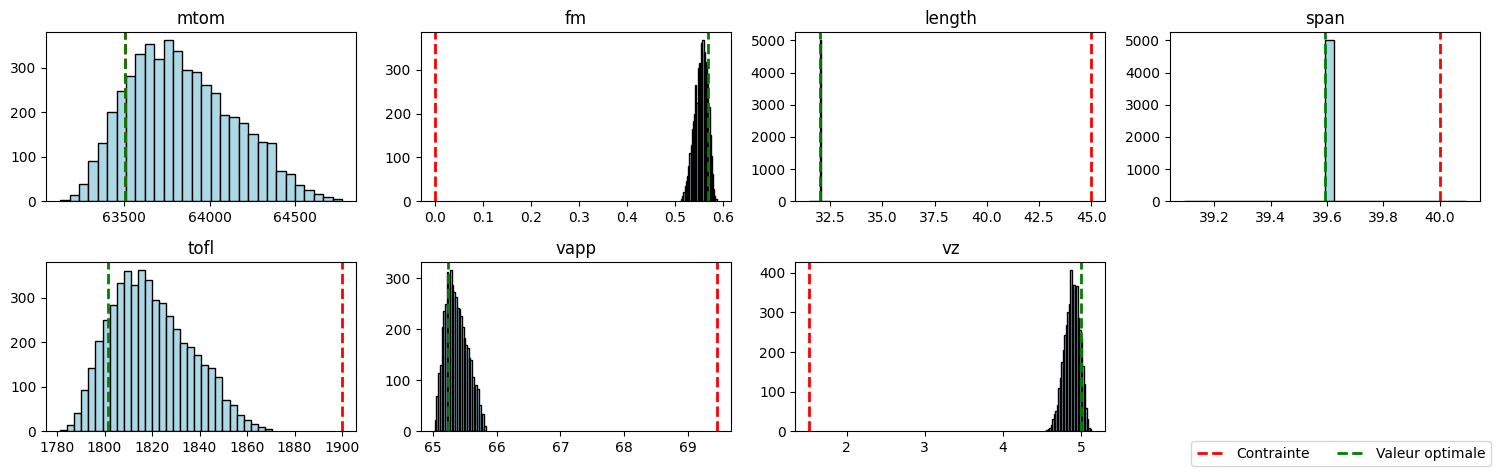

In [12]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

variable_names = ["mtom", "fm", "length", "span", "tofl", "vapp", "vz"]

constraints = [63502.304324127304, 0, 45, 40, 1900, convert_from("kt",135.0), convert_from("ft/min",300.0)] 
optimum_values = [
    63502.304324127304, 
    0.5676963582618872, 
    45-13, 
    40-0.4073526024567613, 
    1900-98.49401362682738, 
    convert_from("kt",135.0)-4.219367536785057, 
    convert_from("ft/min",300.0)+3.4813206097412177
] 

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
axes = axes.ravel()

for ax, name, cons_val, opt_val in zip(axes, variable_names, constraints, optimum_values):
# for ax, name, opt_val in zip(axes, variable_names, optimum_values):

    data = surrogate_dataset.get_view(variable_names=name)
    ax.hist(data, bins=30, color='lightblue', edgecolor='black')
    ax.axvline(cons_val, color='red', linestyle='--', linewidth=2)
    ax.axvline(opt_val, color='green', linestyle='--', linewidth=2)
    ax.set_title(name)

if len(variable_names) < len(axes):
    for ax in axes[len(variable_names):]:
        ax.axis('off')

red_line = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Contrainte')
green_line = Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Valeur optimale')
# fig.legend(handles=[green_line], loc='lower right', ncol=2)
fig.legend(handles=[red_line, green_line], loc='lower right', ncol=2)


plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


# Sobol analysis

In [16]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_disciplines], uncertain_space, 10000)

 WARNING - 18:27:49: No coupling in MDA, switching chain_linearize to True.
    INFO - 18:27:49: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 18:27:49: SobolAnalysisSamplingPhase
    INFO - 18:27:49:    Disciplines: PolyReg_Sampling
    INFO - 18:27:49:    MDO formulation: MDF
    INFO - 18:27:49: Running the algorithm OT_SOBOL_INDICES:
    INFO - 18:28:22:    100%|██████████| 10000/10000 [00:33<00:00, 300.20 it/sec]
    INFO - 18:28:22: *** End SobolAnalysisSamplingPhase execution (time: 0:00:33.444359) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.024023  0.997598  0.525796   32.0  63742.488853   
1          0.996470  1.011547  1.018636  0.553693   32.0  64230.877413   
2          1.012159  1.006022  0.995494  0.550349   32.0  63482.178930   
3          0.999643  1.003814  1.017131  0.562450   32.0  64114.531989   
4          0.999603  1.012760  1.010630  0.549728   32.0  63993.222990   
...             ...       ...       ...       ...    ...           ...   
9995       0.992415  1.015949  1.005742  0.550392   32.0  63824.665771   
9996       1.007491  1.000054  1.027677  0.562223   32.0  64469.030188   
9997       0.991402  1.000257  1.018717  0.573589   32.0  64084.673483   
9998       1.000940  1.012573  0.995685  0.549036   32.0  63498.569322   
9999       1.007142  1.000156  1.001400  0.562327   32.0  63589.265209   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          39.592647  1814.419902  65.182289  4.880738  
1          39.592647  1840.829267  65.604477  4.840791  
2          39.592647  1800.426203  65.139913  4.942273  
3          39.592647  1834.519555  65.574364  4.852086  
4          39.592647  1827.952973  65.444144  4.882837  
...              ...          ...        ...       ...  
9995       39.592647  1818.849345  65.346058  4.965962  
9996       39.592647  1853.780339  65.785094  4.719476  
9997       39.592647  1832.902119  65.606104  4.906055  
9998       39.592647  1801.305575  65.143764  5.000987  
9999       39.592647  1806.175939  65.258793  4.942980  

[10000 rows x 10 columns]

In [21]:
sobol.compute_indices(output_names=["mtom", 'fm', 'tofl', 'vapp', 'vz'])

SobolAnalysis.SensitivityIndices(first={'mtom': [{'aef': array([0.05649824]), 'cef': array([0.13819421]), 'sef': array([0.833594])}], 'fm': [{'aef': array([0.1890603]), 'cef': array([0.80513472]), 'sef': array([0.02185632])}], 'tofl': [{'aef': array([0.05634258]), 'cef': array([0.13797116]), 'sef': array([0.83328032])}], 'vapp': [{'aef': array([0.04518149]), 'cef': array([0.04518164]), 'sef': array([0.95990484])}], 'vz': [{'aef': array([0.40363723]), 'cef': array([0.11157979]), 'sef': array([0.54557596])}]}, second={'mtom': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.07718566]]), 'sef': array([[-0.06921496]])}, 'cef': {'aef': array([[-0.07718566]]), 'cef': array([[0.]]), 'sef': array([[-0.10626559]])}, 'sef': {'aef': array([[-0.06921496]]), 'cef': array([[-0.10626559]]), 'sef': array([[0.]])}}], 'fm': [{'aef': {'aef': array([[0.]]), 'cef': array([[0.03200771]]), 'sef': array([[0.01713627]])}, 'cef': {'aef': array([[0.03200771]]), 'cef': array([[0.]]), 'sef': array([[-0.07616962]]

In [22]:
# pprint.pprint(sobol.indices.first)
# pprint.pprint(sobol.indices.total)

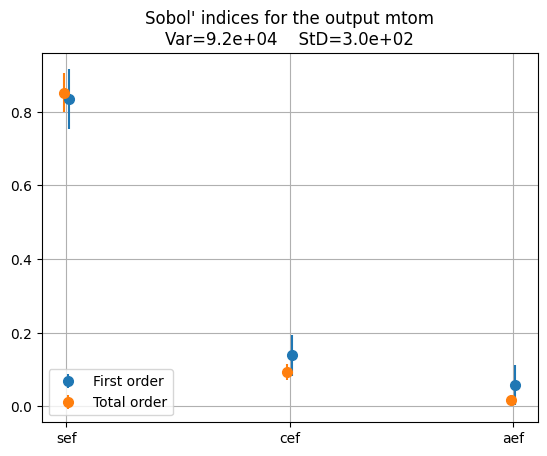

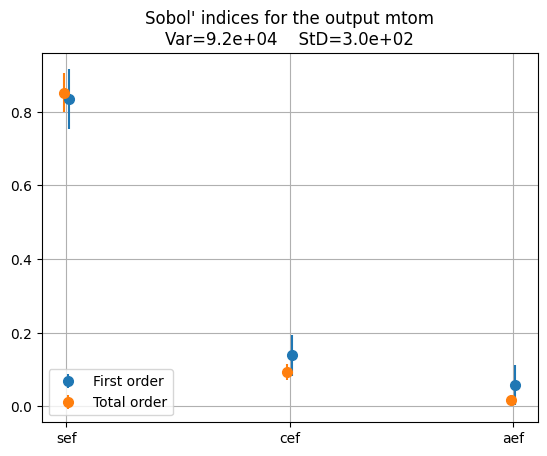

In [23]:
sobol.plot("mtom", save=False, show=True)

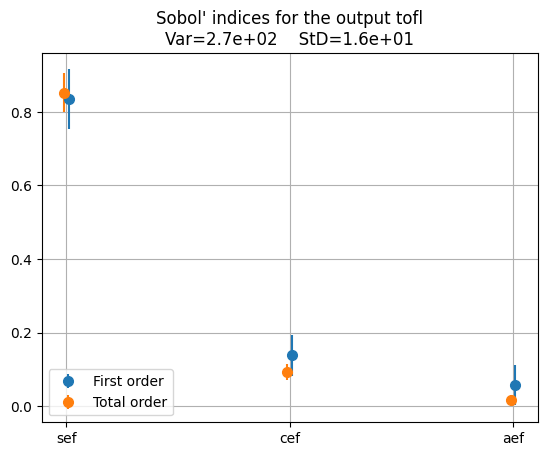

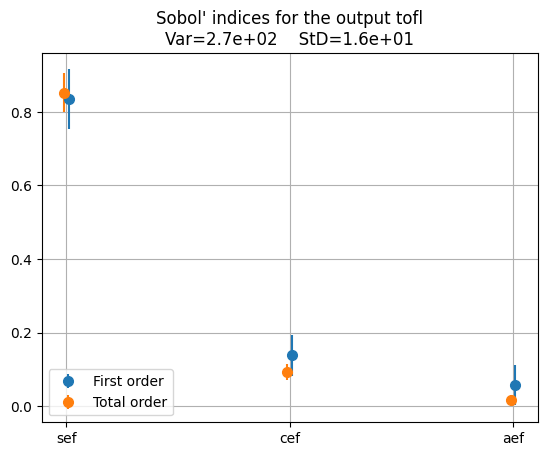

In [24]:
sobol.plot("tofl", save=False, show=True)

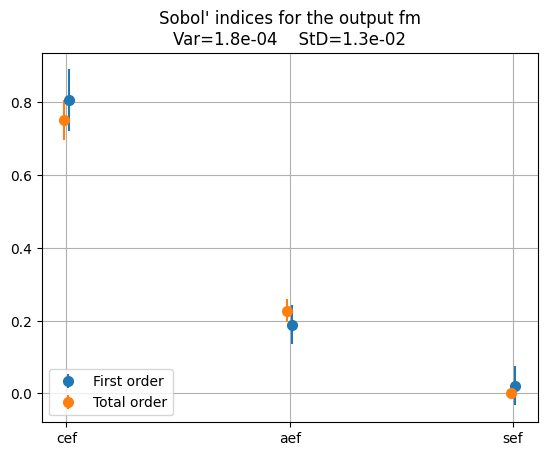

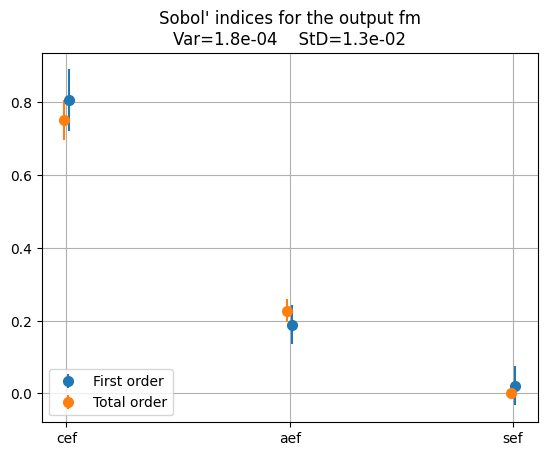

In [25]:
sobol.plot('fm',save=False, show=False)

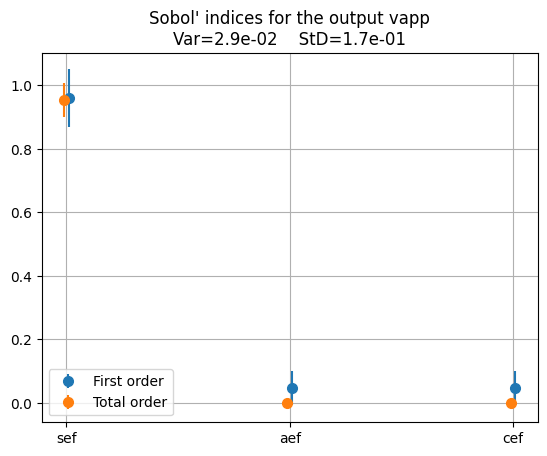

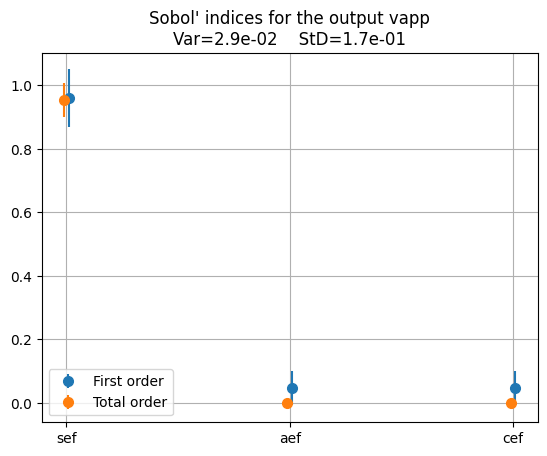

In [26]:
sobol.plot('vapp',save=False, show=False)

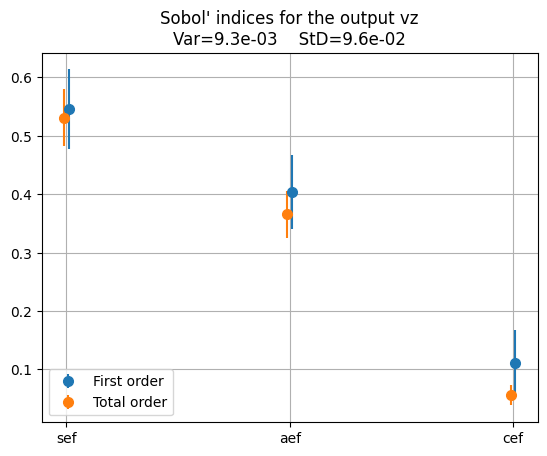

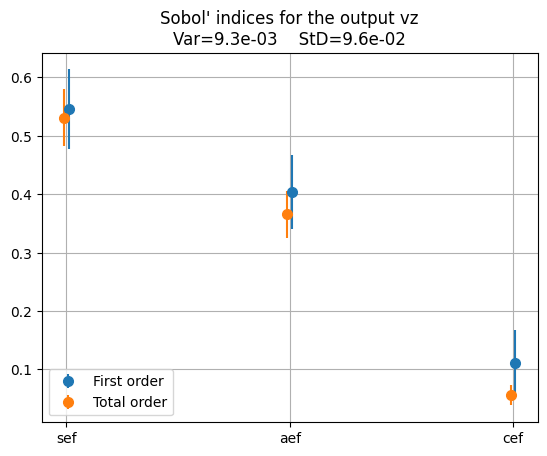

In [27]:
sobol.plot('vz',save=False, show=False)